In [1]:
import math
import random
import time
from jupyterthemes import jtplot

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
gym.logger.set_level(40)
jtplot.style()
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [2]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions
    
#env_name = "Hopper-v2"
env_name = "Pendulum-v0"
#env_name = "BipedalWalker-v2"
env = NormalizedActions(gym.make(env_name))

if env_name == "BipedalWalker-v2":
    num_steps = 2000
    expert_traj = np.load("trajectory/BipedalWalker_100.npy")
    min_buffer_size      = 4000
    batch_size           = 500

if env_name == "Pendulum-v0":
    num_steps = 200
    expert_traj = np.load("trajectory/Pendulum_SAC_50000_-153.npy")
    min_buffer_size      = 1000
    batch_size           = 256

if env_name == "Hopper-v2":
    num_steps = 2900
    expert_traj = np.load("trajectory/ex_traj_Hopper_SAC_500.npy")
    min_buffer_size      = 4000
    batch_size           = 500

num_inputs  = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]    

#Hyper params:
a2c_hidden_size      = 128
discrim_hidden_size  = 128
lr                   = 3e-4
num_G_updates        = 5
num_D_updates        = 1

print(num_inputs,num_outputs)

3 1


In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        
class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(Actor, self).__init__()
        
        self.linear1  = nn.Linear(num_inputs, hidden_size)
        self.linear2  = nn.Linear(hidden_size, hidden_size)
        self.linear_actor  = nn.Linear(hidden_size, num_outputs)
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        self.apply(init_weights)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        mu = self.linear_actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist

class Critic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(Critic, self).__init__()
        
        self.linear1  = nn.Linear(num_inputs, hidden_size)
        self.linear2  = nn.Linear(hidden_size, hidden_size)
        self.linear_critic  = nn.Linear(hidden_size, 1)
        self.apply(init_weights)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        value = self.linear_critic(x)
        return value
    
class Discriminator(nn.Module):
    def __init__(self, num_inputs, hidden_size):
        super(Discriminator, self).__init__()
        
        self.linear1   = nn.Linear(num_inputs, hidden_size)
        self.linear2   = nn.Linear(hidden_size, hidden_size)
        self.linear3   = nn.Linear(hidden_size, 1)
        self.linear3.weight.data.mul_(0.1)
        self.linear3.bias.data.mul_(0.0)
    
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        prob = F.sigmoid(self.linear3(x))
        return prob
    
def expert_reward(state, action):
    state_action = torch.cat((state,action),1)
    # return - np.log(1-discriminator(state_action).cpu().data.numpy()
    # return np.log(discriminator(state_action).cpu().data.numpy())
    return np.log(discriminator(state_action).cpu().data.numpy()) - np.log(1-discriminator(state_action).cpu().data.numpy())

In [4]:
def plot(frame_idx, rewards, D_fake, D_real):
    clear_output(True)
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.subplot(122)
    plt.title('D_fake %s  D_real %s' % (D_fake[-1] ,D_real[-1]))
    plt.plot(D_fake)
    plt.plot(D_real)
#    plt.subplot(223)
#    plt.title('loss %s' % (losses[-1:]))
#    plt.plot(losses)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist = actor(state)
        # next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        next_state, reward, done, _ = env.step(dist.mean.detach().cpu().numpy()[0])
        state = next_state
#        time.sleep(0.01)
#        print(reward)
        if vis: env.render()
        total_reward += reward
    return total_reward

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.995, tau=0.97):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [6]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

# Batchサンプリング
def sample_batch(states, actions, log_probs, returns, advantages):
    batch_iteration_num = states.shape[0] // batch_size
    perm = np.arange(states.shape[0])
    np.random.shuffle(perm)
    states, actions, log_probs, returns, advantages= \
        states[perm], actions[perm], log_probs[perm], returns[perm], advantages[perm]
    for i in range (batch_iteration_num):
        ids = slice(i * batch_size, min((i + 1) * batch_size, states.shape[0]))
        yield states[ids, :], actions[ids, :], log_probs[ids, :], returns[ids, :], advantages[ids, :]

def ppo_update(states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(num_G_updates):
        for state, action, old_log_probs, return_, advantage in sample_batch(states, actions, log_probs, returns, advantages):
            #dist, value = model(state)
            dist = actor(state)
            value = critic(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean() - 0.001 * entropy
            #critic_loss = (return_ - value).pow(2).mean()
            critic_loss = critic_criterion(value, return_)
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()
            
def discriminator_update():
    expert_state_action = expert_traj[np.random.randint(0, expert_traj.shape[0], states.shape[0]), :]
    expert_state_action = torch.FloatTensor(expert_state_action).to(device)
    fake = discriminator(state_actions)
    real = discriminator(expert_state_action)
    
#    discrim_loss = discrim_criterion(fake, torch.ones((states.shape[0], 1)).to(device)) + \
#            discrim_criterion(real, torch.zeros((expert_state_action.size(0), 1)).to(device))
    discrim_loss = discrim_criterion(real, torch.ones((expert_state_action.size(0), 1)).to(device)) + \
            discrim_criterion(fake, torch.zeros((states.shape[0], 1)).to(device))



    optimizer_discrim.zero_grad()
    discrim_loss.backward()
    optimizer_discrim.step()
    return real,fake

In [7]:
actor = Actor(num_inputs, num_outputs, a2c_hidden_size).to(device)
critic = Critic(num_inputs, num_outputs, a2c_hidden_size).to(device)
discriminator = Discriminator(num_inputs + num_outputs, discrim_hidden_size).to(device)
discrim_criterion = nn.BCELoss()
critic_criterion = nn.MSELoss()

optimizer_actor  = optim.Adam(actor.parameters(), lr=lr)
optimizer_critic  = optim.Adam(critic.parameters(), lr=lr)
optimizer_discrim = optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
test_rewards = []
D_real    = []
D_fake    = []
max_frames = 50000000
frame_idx = 0

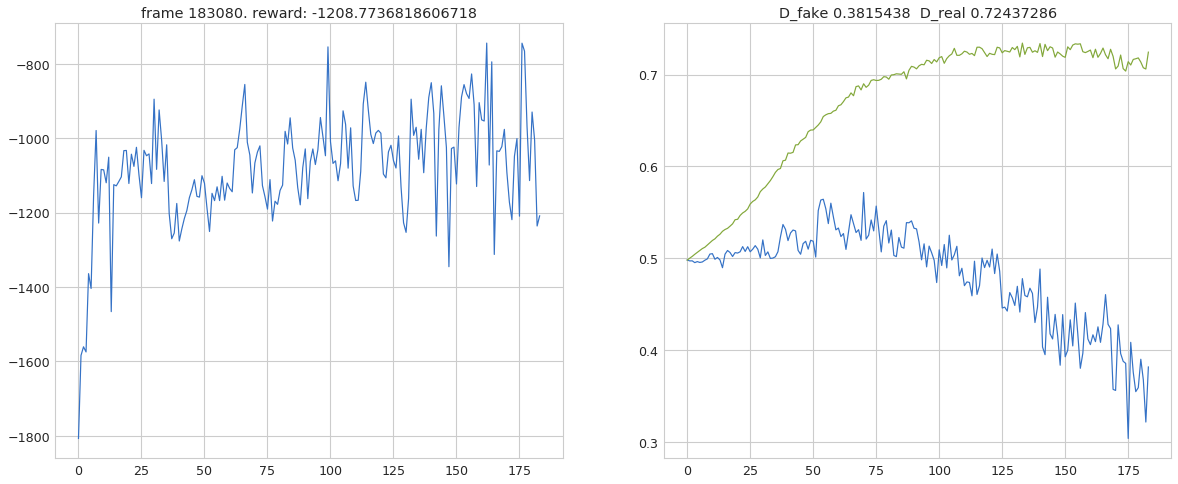

done time: 200 episode reward:
done time: 200 episode reward:
done time: 200 episode reward:
done time: 200 episode reward:
done time: 200 episode reward:
torch.Size([1000, 1]) torch.Size([1000, 1])


In [ ]:
done = False

# 最大フレームまでエポックループ
while frame_idx < max_frames:
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    returns   = []

    # 更新バッファサイズまでエピソードループ
    while (len(states) < min_buffer_size):
        state = env.reset()
        state = np.reshape(state, (1,-1))
        rewards_ = []
        masks_ = []
        values_ = []
        
        # エピソード終了までタイムステップループ
        for i in range(1, num_steps+1):
            state = torch.FloatTensor(state).to(device)
            dist = actor(state)
            value = critic(state)            
            action = dist.sample()
            action_numpy = action.cpu().numpy()
            next_state, _, done, _ = env.step(action_numpy)

            #env適応
            next_state = np.reshape(next_state, (1,-1))
            done = np.reshape(done, (1,))
            
            if i == num_steps:
                done == True
            reward = expert_reward(state, action)
            log_prob = dist.log_prob(action).to(device)
            
            # log
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            
            rewards_.append(torch.FloatTensor(reward).to(device))
            masks_.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
            values_.append(value)

            if done:
                break   
            state = next_state
            frame_idx += 1

        # エピソード終了後
        print("done time:", i, "episode reward:")
        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns_ = compute_gae(next_value, rewards_, masks_, values_)
        returns.extend(returns_)
        rewards.extend(rewards_)
        masks.extend(masks_)
        values.extend(values_)

    returns   = torch.cat(returns).detach().to(device)
    log_probs = torch.cat(log_probs).detach().to(device)
    values    = torch.cat(values).detach().to(device)
    states    = torch.cat(states).to(device)
    actions   = torch.cat(actions).to(device)
    advantage = returns - values
    # Discriminator
    state_actions = torch.cat([states, actions], 1)
    for _ in range(num_D_updates):
        real, fake = discriminator_update()

    # Generator
    ppo_update(states, actions, log_probs, returns, advantage)
    
    # Test
    test_reward = np.mean([test_env() for _ in range(3)])
    test_rewards.append(test_reward)
    D_real.append(torch.mean(real).data.cpu().numpy())
    D_fake.append(torch.mean(fake).data.cpu().numpy())
    plot(frame_idx, test_rewards, D_fake, D_real)

In [ ]:
test_env(True)

In [ ]:
# model save

MODEL_PATH_ACTOR = 'asset/GAIL/GAIL_actor.pth'
MODEL_PATH_CRITIC = 'asset/GAIL/GAIL_critic.pth'
MODEL_PATH_DISCRIMINATOR = 'asset/GAIL/GAIL_discriminator.pth'

torch.save(actor.state_dict(), MODEL_PATH_ACTOR)
torch.save(critic.state_dict(), MODEL_PATH_CRITIC)
torch.save(discriminator.state_dict(), MODEL_PATH_DISCRIMINATOR)


In [ ]:
2000 140で収束